# Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn import linear_model
import torch
import torch.nn as nn
from tqdm import tqdm

from sklearn.metrics import roc_auc_score

In [2]:
DATA_PATH = '../data'
MODEL_PATH = '../src/models'

### Util Functions

In [3]:
def train_valid_test_split(X, y, TEST_SIZE=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size = TEST_SIZE, 
        random_state=random_state
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, 
        y_train, 
        test_size = TEST_SIZE, 
        random_state=random_state
    )

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [4]:
def get_metrics(pred, actual, display=True):
    cm = confusion_matrix(actual, pred)
    tn, fp, fn, tp = cm.ravel()

    TPR = tp / (tp + fn)
    FPR = tn / (tn + fp)
    roc_auc = roc_auc_score(actual, pred)
    if (display):
        print(f"Accuracy: {np.mean(pred == actual):.4f}")
        print(f"tn:  {tn},  fp:  {fp},  fn:  {fn}, tp:  {tp}")
        print(f"Precision:\t\t\t{tp / (tp + fp):.5f}")
        print(f"Recall:\t\t\t\t{tp / (tp + fn):.5f}")
        print(f"TPR:\t\t\t\t{TPR:.5f}")
        print(f"FPR:\t\t\t\t{FPR:.5f}")
        print(f"Positive likelihood ratio:\t{TPR/FPR:.5f}")
        print(f"Negative likelihood ratio:\t{FPR/TPR:.5f}")
        print(f"ROC-AUC Score:\t{roc_auc:.5f}")
        return
    return [tn, fp, fn, tp, TPR, FPR, TPR/FPR, FPR/TPR, roc_auc]

# Prototype Model to Predict Default Risk

# Prototype 2: Basic Sequential NN

### Get Data

In [5]:
# Get SNN Data
feature_matrix = pd.read_csv(f'{DATA_PATH}/processed/feature_matrix.csv')
feature_matrix.head()

,FPF_TARGET,minbalance,maxbalance,stdbalance,total_balance,avg_monthly_spending,num_monthly_purchase,num_savings_transfer,unsufficient_balance,account_count,...,MORTGAGE_prop,OVERDRAFT_prop,PAYCHECK_prop,RENT_prop,SELF_TRANSFER_prop,TAX_prop,TRAVEL_prop,UNCATEGORIZED_prop,Overdraft Count,cum_weighted_def_val
0,0.0,0.52,253.01,125.590741,857.150161,5531.648836,79.521124,2.0,5,5,...,0.104994,0.000000,0.0,0.0,0.142151,0.000000,0.000830,0.089842,0.0,0.000000
1,0.0,6.11,31564.64,13215.093678,43016.714011,64529.528960,160.211203,0.0,4,4,...,0.000000,0.000000,0.0,0.0,0.016751,0.001093,0.004267,0.246412,0.0,0.000000
2,0.0,1092.82,31229.66,17278.364208,14667.666944,16997.552350,92.855324,0.0,3,3,...,0.000000,0.000000,0.0,0.0,0.261025,0.000000,0.002219,0.001825,0.0,0.000000
3,0.0,40.45,6425.61,4514.989935,-4188.933058,9778.291345,95.104454,0.0,2,2,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000142,0.016086,0.0,0.000000
4,0.0,0.40,1009.99,438.528721,-2630.480387,16837.676865,119.566068,0.0,4,4,...,0.000000,0.057938,0.0,0.0,0.000000,0.000000,0.016481,0.140562,1.0,318.890041


In [6]:
# Train Test Split
TEST_SIZE = 0.2
X = feature_matrix.iloc[:,1:].to_numpy()
y = feature_matrix.iloc[:,0].to_numpy()

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(
    X, 
    y, 
    TEST_SIZE = TEST_SIZE, 
    random_state = 42
)

### Define Model

In [7]:
# Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 12),
    nn.ReLU(),
    nn.Linear(12, 24),
    nn.ReLU(),
    nn.Linear(24, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
    nn.Sigmoid()
)

In [8]:
# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Training

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [10]:
def train_SNN(
        model, 
        loss_fn, 
        optimizer, 
        X_train_tensor, 
        y_train_tensor, 
        X_valid_tensor, 
        y_valid_tensor, 
        n_epochs=200,
        batch_size=64, 
        display=True):
    
    batch_start = torch.arange(0, X_train_tensor.shape[0], batch_size)
    train_history = []
    valid_history = []
    best_valid = np.inf
    
    # training loop
    bar = tqdm(range(n_epochs))
    for epoch in bar:
        model.train()
        bar.set_description(f"Epoch {epoch+1}")
        for start in batch_start:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred_train = model(X_train_tensor)
        y_pred_valid = model(X_valid_tensor)
        train_loss = float(loss_fn(y_pred_train, y_train_tensor))
        valid_loss = float(loss_fn(y_pred_valid, y_valid_tensor))
        
        bar.set_postfix(Train_MSE = float(train_loss), Valid_MSE = float(valid_loss))
        train_history.append(train_loss)
        valid_history.append(valid_loss)

        if (valid_loss < best_valid):
            torch.save(model.state_dict(), f'{MODEL_PATH}/nn_base_params.pt')

    if display:
        print(f"Best Epoch: {np.argmin(valid_history)}")
        print(f"Loss: {np.min(valid_history)}")
    model.load_state_dict(torch.load(f'{MODEL_PATH}/nn_base_params.pt'))
    return model, train_history, valid_history

In [11]:
# training parameters
n_epochs = 200   # number of epochs to run
batch_size = 64  # size of each batch

# train model
model, train_history, valid_history = train_SNN(
    model, 
    loss_fn,
    optimizer,
    X_train_tensor, 
    y_train_tensor, 
    X_valid_tensor, 
    y_valid_tensor, 
    n_epochs = n_epochs,
    batch_size = batch_size,
    display=False
)

Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: 100%|██████████| 200/200 [00:14<00:00, 14.08it/s, Train_MSE=0.176, Valid_MSE=0.706]


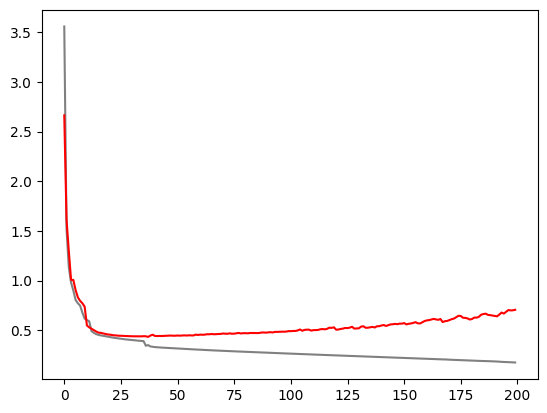

In [12]:
plt.plot(train_history, 'gray')
plt.plot(valid_history, 'r')

### Evaluate Model

In [13]:
# train_pred = model.predict(X_train)
def standardize_output(arr):
    return (1 / (1 + np.e ** (-1 * arr)))

def find_best_prob(pred_prob, actual, display=True):
    best_prob = 0
    best_score = -np.inf
    prob_interval = 0.05
    with np.errstate(divide='ignore'):
        if display:
            print(
                f"i\t" + 
                f"roc_auc\t" + 
                f"acc\t" + 
                f"conf_matrix" + 
                "\n==================================================="
            )
        for i in np.arange(0, 1.0, prob_interval):
            pred = pred_prob > i
            metrics = get_metrics(pred, actual, display=False)
            
            score = metrics[8]

            if display:
                print(
                    f"{i:.2f}\t" + 
                    f"{score:0.3f}\t" + 
                    f"{((metrics[0] + metrics[3]) / np.sum(metrics[:4]) * 100):.2f}\t" + 
                    f"{metrics[:4]}"
                )

            if (score > best_score):
                best_score = score
                best_prob = i
    if display: print(f"Best Threshold: {best_prob:0.2f}")
    return best_prob

In [14]:
valid_pred_prob = model(X_valid_tensor).detach().numpy()[:,0]
# valid_pred_prob = standardize_output(valid_pred_prob)
threshold = find_best_prob(valid_pred_prob, y_valid)
valid_pred = valid_pred_prob > threshold

test_pred_prob = model(X_test_tensor).detach().numpy()[:,0]
# test_pred_prob = standardize_output(test_pred_prob)
test_pred = test_pred_prob > threshold

i	roc_auc	acc	conf_matrix
0.00	0.545	28.51	[34, 341, 0, 102]
0.05	0.744	73.17	[271, 104, 24, 78]
0.10	0.734	75.05	[286, 89, 30, 72]
0.15	0.741	76.73	[295, 80, 31, 71]
0.20	0.746	77.99	[302, 73, 32, 70]
0.25	0.751	79.87	[313, 62, 34, 68]
0.30	0.734	79.45	[315, 60, 38, 64]
0.35	0.715	79.87	[323, 52, 44, 58]
0.40	0.690	80.50	[334, 41, 52, 50]
0.45	0.657	79.25	[335, 40, 59, 43]
0.50	0.641	79.45	[341, 34, 64, 38]
0.55	0.604	78.20	[343, 32, 72, 30]
0.60	0.595	78.41	[347, 28, 75, 27]
0.65	0.581	79.04	[355, 20, 80, 22]
0.70	0.573	79.45	[360, 15, 83, 19]
0.75	0.561	79.25	[362, 13, 86, 16]
0.80	0.547	79.25	[366, 9, 90, 12]
0.85	0.537	79.45	[370, 5, 93, 9]
0.90	0.523	79.45	[374, 1, 97, 5]
0.95	0.508	78.83	[374, 1, 100, 2]
Best Threshold: 0.25


In [15]:
print("Validation:")
get_metrics(valid_pred, y_valid)
print("===========================")
print("Testing:")
get_metrics(test_pred, y_test)

Validation:
Accuracy: 0.7987
tn:  313,  fp:  62,  fn:  34, tp:  68
Precision:			0.52308
Recall:				0.66667
TPR:				0.66667
FPR:				0.83467
Positive likelihood ratio:	0.79872
Negative likelihood ratio:	1.25200
ROC-AUC Score:	0.75067
Testing:
Accuracy: 0.7819
tn:  409,  fp:  89,  fn:  41, tp:  57
Precision:			0.39041
Recall:				0.58163
TPR:				0.58163
FPR:				0.82129
Positive likelihood ratio:	0.70820
Negative likelihood ratio:	1.41203
ROC-AUC Score:	0.70146


# Testing Distribution Differences

In [16]:
from scipy import stats

In [17]:
X_valid_df = pd.DataFrame(
    # np.array([stats.zscore(col) for col in X_valid])
    np.array([stats.zscore(col) for col in X_valid.T]).T
    # X_valid
)
X_valid_df.rename(
    dict(zip(np.arange(X.shape[1]), feature_matrix.iloc[:,1:].columns)),
    axis=1,
    inplace=True
)
X_valid_df['pred_y'] = valid_pred.astype(float)
X_valid_df['y'] = y_valid
X_valid_df.head()

,minbalance,maxbalance,stdbalance,total_balance,avg_monthly_spending,num_monthly_purchase,num_savings_transfer,unsufficient_balance,account_count,ACCOUNT_FEES_slp,...,PAYCHECK_prop,RENT_prop,SELF_TRANSFER_prop,TAX_prop,TRAVEL_prop,UNCATEGORIZED_prop,Overdraft Count,cum_weighted_def_val,pred_y,y
0,-0.228291,2.130508,2.296482,-1.164311,-0.247038,-0.649753,-0.267590,0.950517,0.950517,0.052306,...,-0.070517,-0.238215,-0.268206,-0.153520,-0.516166,-0.819520,-0.19803,-0.146125,0.0,0.0
1,-0.155039,-0.287457,-0.224128,-0.029354,-0.396562,-0.474335,-0.267590,-0.408993,-0.408993,0.650413,...,-0.070517,-0.195254,-0.268206,-0.153520,-0.213414,-0.008489,-0.19803,-0.147424,0.0,0.0
2,-0.258300,-0.328896,-0.224128,-0.061951,-0.403910,-0.837626,-0.267590,-0.408993,-0.408993,0.075643,...,-0.070517,-0.238215,-0.268206,-0.153520,2.662241,-0.822909,-0.19803,-0.147424,0.0,0.0
3,-0.229354,-0.317280,-0.224128,0.050388,-0.419425,0.898274,3.275352,-0.408993,-0.408993,0.075643,...,-0.070517,-0.238215,-0.133349,-0.153520,1.482965,-0.542217,-0.19803,-0.147424,1.0,0.0
4,-0.198394,-0.265151,-0.173346,-0.105624,-0.216573,0.446334,-0.267590,0.270762,0.270762,0.075643,...,-0.070517,-0.238215,-0.107913,0.776192,-0.047821,-0.420963,-0.19803,-0.147424,0.0,0.0


In [18]:
valid_pred_0 = X_valid_df[X_valid_df['pred_y'] == 0].iloc(axis=1)[:-2]
valid_pred_1 = X_valid_df[X_valid_df['pred_y'] == 1].iloc(axis=1)[:-2]

223 347 223 130


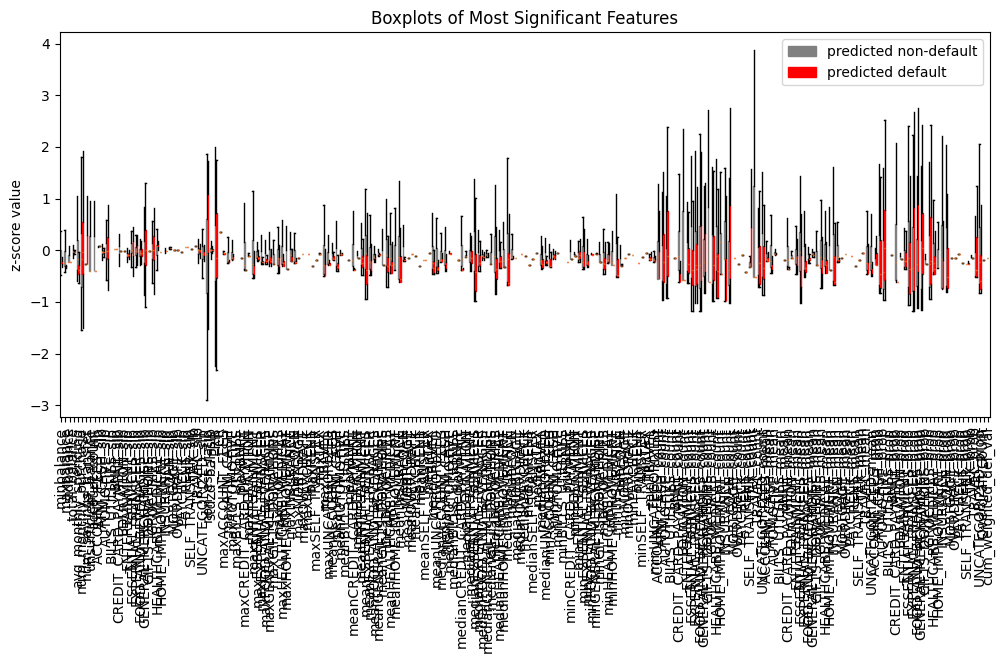

In [19]:
nfeatures = valid_pred_0.shape[1]
step_size = 3

fig, ax = plt.subplots(figsize=(12, 5))

bp0 = ax.boxplot(
    valid_pred_0, 
    positions=np.arange(0,nfeatures*step_size,step_size),
    patch_artist=True, 
    boxprops=dict(facecolor='gray', color='gray'),
    showfliers=False
)

bp1 = ax.boxplot(
    valid_pred_1, 
    positions=np.arange(1,nfeatures*step_size,step_size),
    patch_artist=True, 
    boxprops=dict(facecolor='red', color='red'),
    showfliers=False
)

ax.set_title("Boxplots of Most Significant Features")
ax.legend([bp0["boxes"][0], bp1["boxes"][0]], ['predicted non-default', 'predicted default'], loc='upper right')
ax.set_ylabel('z-score value')
# ax.set_ylim(-0.4, 0.3)
ax.set_xticks(np.arange(0.5, nfeatures*step_size,step_size))
ax.set_xticklabels(valid_pred_0.columns, rotation=90);

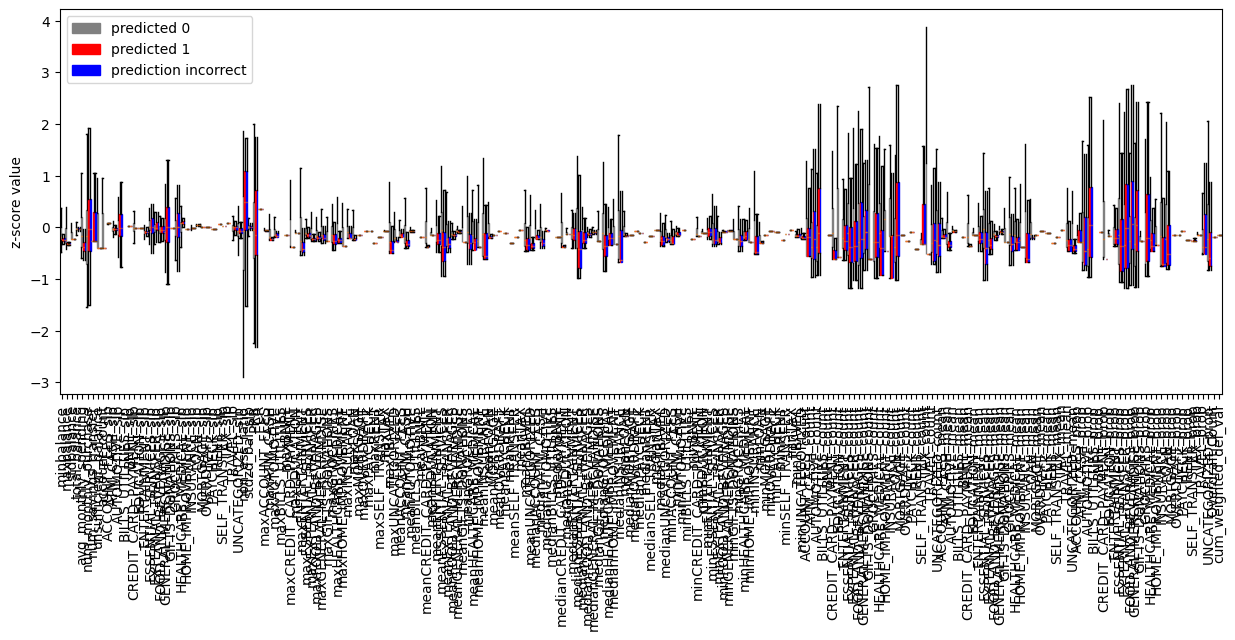

In [20]:
valid_pred_incorrect = X_valid_df[X_valid_df['pred_y'] != X_valid_df['y']].iloc(axis=1)[:40]

fig, ax = plt.subplots(figsize=(15, 5))


bp0 = ax.boxplot(
    valid_pred_0, 
    positions=np.arange(0,nfeatures*step_size,step_size),
    patch_artist=True, 
    boxprops=dict(facecolor='gray', color='gray'),
    showfliers=False
)

bp1 = ax.boxplot(
    valid_pred_1, 
    positions=np.arange(1,nfeatures*step_size,step_size),
    patch_artist=True, 
    boxprops=dict(facecolor='red', color='red'),
    showfliers=False
)
bp2 = ax.boxplot(
    valid_pred_1, 
    positions=np.arange(2,nfeatures*step_size,step_size),
    patch_artist=True, 
    boxprops=dict(facecolor='blue', color='blue'),
    showfliers=False
)

ax.legend([bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0]], ['predicted 0', 'predicted 1', 'prediction incorrect'], loc='upper left')
ax.set_ylabel('z-score value')
ax.set_xticks(np.arange(0.5, nfeatures*step_size,step_size))
ax.set_xticklabels(valid_pred_0.columns, rotation=90);

In [21]:
X_valid_raw = pd.DataFrame(X_valid)
X_valid_raw.rename(
    dict(zip(np.arange(X.shape[1]), feature_matrix.iloc[:,1:].columns)),
    axis=1,
    inplace=True
)
X_valid_raw['pred_y'] = valid_pred.astype(float)
X_valid_raw['y'] = y_valid

In [22]:
X_valid_raw_0 = X_valid_raw[X_valid_raw['pred_y'] == 0]
X_valid_raw_1 = X_valid_raw[X_valid_raw['pred_y'] == 1]

In [23]:
raw_0_median_nonzero = [np.median(valid_pred_0[col][valid_pred_0[col] != 0]) for col in valid_pred_0.columns[:-2]]
raw_1_median_nonzero = [np.median(valid_pred_1[col][valid_pred_1[col] != 0]) for col in valid_pred_1.columns[:-2]]

/var/folders/0_/tww2_mb540ldlyk4js_q8l8r0000gn/T/ipykernel_75286/150201741.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(valid_pred_0.columns[:-2], rotation=90);


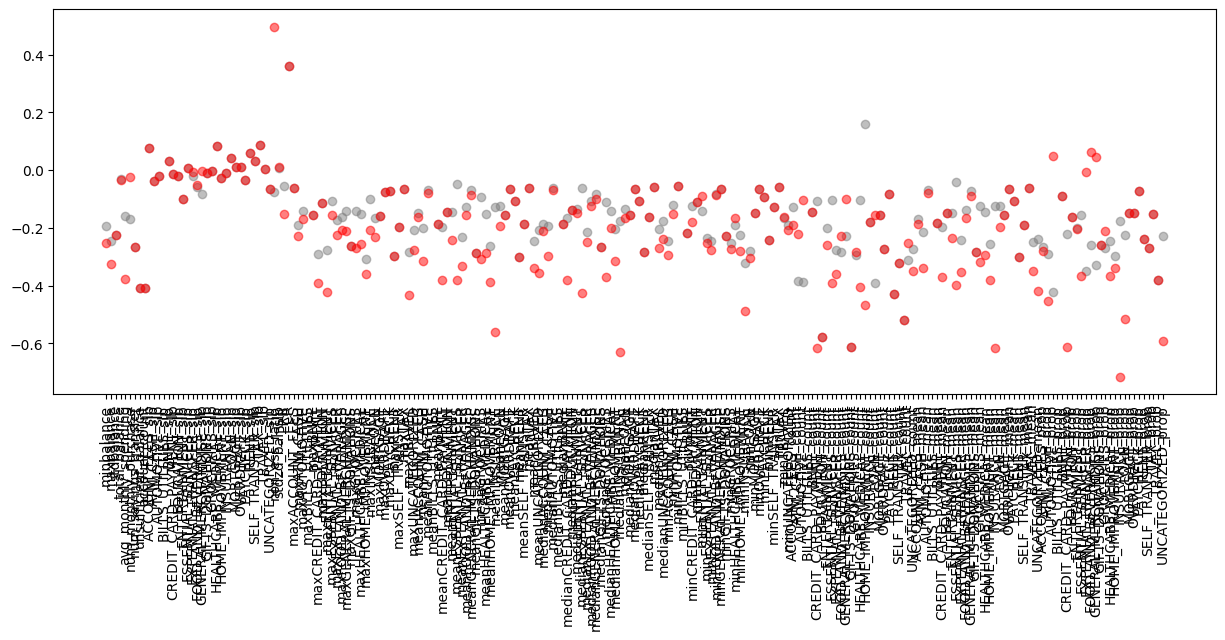

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(
    valid_pred_0.columns[:-2], 
    raw_0_median_nonzero,
    color='gray',
    alpha=0.5
)
ax.scatter(
    valid_pred_0.columns[:-2], 
    raw_1_median_nonzero,
    color='red',
    alpha=0.5
)

ax.set_xticklabels(valid_pred_0.columns[:-2], rotation=90);

In [25]:
median_dist = [0 if np.isnan(x) else x for x in np.abs((np.array(raw_0_median_nonzero) - np.array(raw_1_median_nonzero)))]
median_dist = dict(zip(valid_pred_0.columns[:-2], median_dist))
median_dist = {key: median_dist[key] for key in sorted(median_dist, key=lambda x: median_dist[x], reverse=True)}

/var/folders/0_/tww2_mb540ldlyk4js_q8l8r0000gn/T/ipykernel_75286/1385838063.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keys, rotation=90);


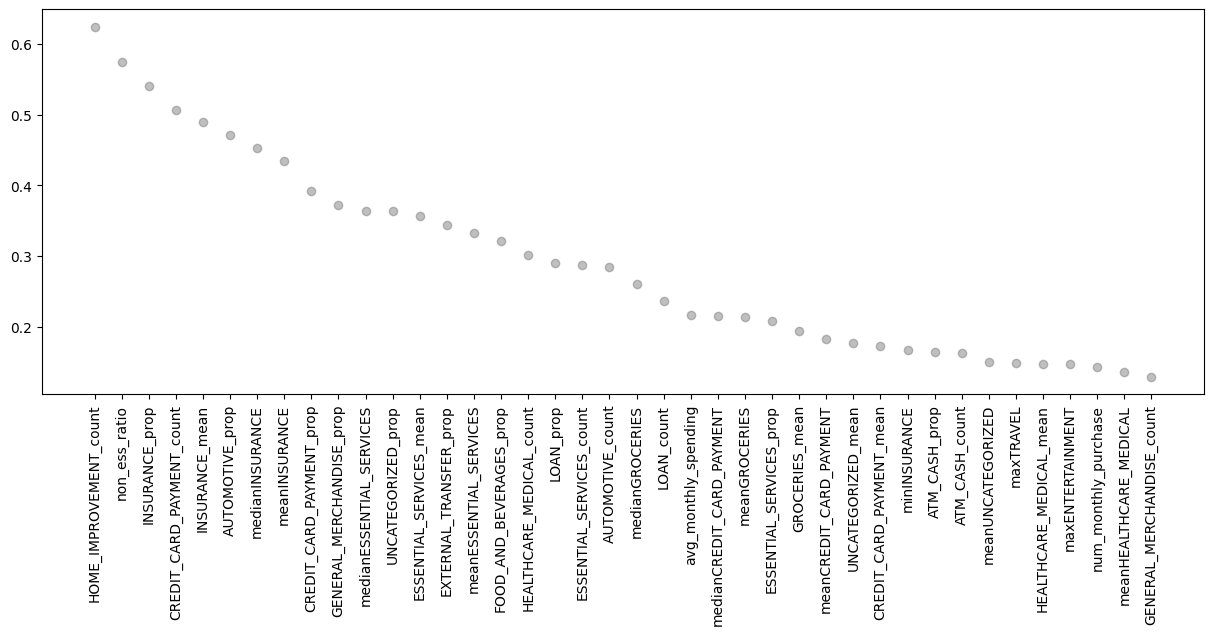

In [26]:
keys = list(median_dist.keys())[:40]
values = list(median_dist.values())[:40]

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(
    keys, 
    values,
    color='gray',
    alpha=0.5
)
ax.set_xticklabels(keys, rotation=90);

# Create Reduced Features

In [29]:
# Get top 40 features
SNN_diff_feature_matrix = feature_matrix[keys]
# Append target to beginning of feature matrix
SNN_diff_feature_matrix.insert(
    0, 
    column='FPF_TARGET',
    value=feature_matrix['FPF_TARGET']
)
# Save feature matrix
SNN_diff_feature_matrix.to_csv(
    f'{DATA_PATH}/processed/SNN_diff_feature_matrix.csv', 
    index=False
)